# Active Inference Mountain car

In [2]:
import Pkg; Pkg.activate("."); Pkg.instantiate();

  Activating project at `~/PhD/RxInfer.jl/examples`


In [3]:
using RxInfer, Plots

A group of friends is going to a camping site that is located on the biggest mountain in the Netherlands. They use an electric car for the trip. When they are almost there, the car's battery is almost empty and is therefore limiting the engine force. Unfortunately, they are in the middle of a valley and don't have enough power to reach the camping site. Night is falling and they still need to reach the top of the mountain. As rescuers, let us develop an Active Inference (AI) agent that can get them up the hill with the limited engine power.

## The environmental process of the mountain
Firstly, we specify the environmental process according to Ueltzhoeffer (2017) "Deep active inference". This process shows how the environment evolves after interacting with the agent.

Particularly, let's denote $z_t = (\phi_t, \,\,\dot{\phi_t})$ as the environmental state depending on the position $\phi_t$ and velocity $\dot{\phi_t}$ of the car; $a_t$ as the action of the environment on the car. Then the evolution of the state is described as follows  
\begin{align} 
\dot{\phi_t} &= \dot{\phi}_{t-1} + F_g(\phi_{t-1}) + F_f(\dot{\phi}_{t-1}) + F_a(a_t)\\
\phi_t &= \phi_{t-1} + \dot{\phi_t} 
\end{align}
where $F_g(\phi_{t-1})$ is the gravitational force of the hill landscape that depends on the car's position
$$ F_g(\phi) =  \begin{cases}
        -0.05(2\phi + 1) , \, & \mathrm{if} \, \phi < 0 \\
        -0.05 \left[(1 + 5\phi^2)^{-\frac{1}{2}} + \phi^2 (1 + 5\phi^2)^{-\frac{3}{2}} + \frac{1}{16}\phi^4 \right], \, & \mathrm{otherwise}
        \end{cases};$$

$F_f(\dot{\phi})$ is the friction on the car defined through the car's velocity $$F_f(\dot{\phi})  = -0.1 \, \dot{\phi}\,;$$ and $F_a(a)$ is the force engine $$F_a(a) = 0.04 \,\mathrm{tanh}(a).$$
Since the car is on low battery, we use the $tanh(\cdot)$ function to limit the force engine to the interval [-0.04, 0.04].

In the cell below, the ```create_physics``` function defines forces $F_g,\, F_f,\, F_a\,$; and the ```create_world``` function defines the environmental process of the mountain.


In [4]:
import HypergeometricFunctions: _₂F₁

function create_physics(; engine_force_limit = 0.04, friction_coefficient = 0.1)
    # Engine force as function of action
    Fa = (a::Real) -> engine_force_limit * tanh(a) 

    # Friction force as function of velocity
    Ff = (y_dot::Real) -> -friction_coefficient * y_dot 
    
    # Gravitational force (horizontal component) as function of position
    Fg = (y::Real) -> begin
        if y < 0
            0.05*(-2*y - 1)
        else
            0.05*(-(1 + 5*y^2)^(-0.5) - (y^2)*(1 + 5*y^2)^(-3/2) - (y^4)/16)
        end
    end
    
    # The height of the landscape as a function of the horizontal coordinate
    height = (x::Float64) -> begin
        if x < 0
            h = x^2 + x
        else
            h = x * _₂F₁(0.5,0.5,1.5, -5*x^2) + x^3 * _₂F₁(1.5, 1.5, 2.5, -5*x^2) / 3 + x^5 / 80
        end
        return 0.05*h
    end

    return (Fa, Ff, Fg,height)
end;

function create_world(; Fg, Ff, Fa, initial_position = -0.5, initial_velocity = 0.0)

    y_t_min = initial_position
    y_dot_t_min = initial_velocity
    
    y_t = y_t_min
    y_dot_t = y_dot_t_min
    
    execute = (a_t::Float64) -> begin
        # Compute next state
        y_dot_t = y_dot_t_min + Fg(y_t_min) + Ff(y_dot_t_min) + Fa(a_t)
        y_t = y_t_min + y_dot_t
    
        # Reset state for next step
        y_t_min = y_t
        y_dot_t_min = y_dot_t
    end
    
    observe = () -> begin 
        return [y_t, y_dot_t]
    end
        
    return (execute, observe)
end

create_world (generic function with 1 method)

Let's visualize the mountain landscape and the situation of the car. 

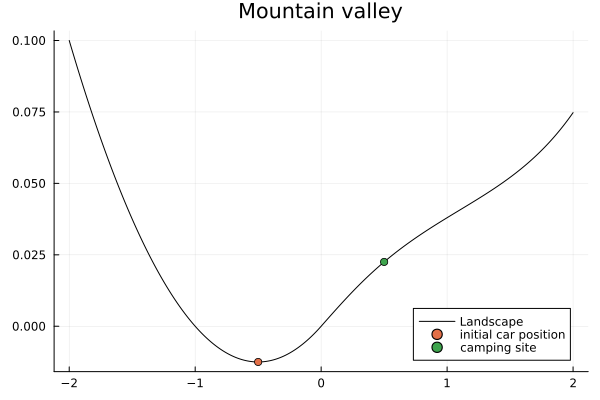

In [5]:
engine_force_limit   = 0.04
friction_coefficient = 0.1

Fa, Ff, Fg, height = create_physics(
    engine_force_limit = engine_force_limit,
    friction_coefficient = friction_coefficient
);
initial_position = -0.5
initial_velocity = 0.0

x_target = [0.5, 0.0] 

valley_x = range(-2, 2, length=400)
valley_y = [ height(xs) for xs in valley_x ]
plot(valley_x, valley_y, title = "Mountain valley", label = "Landscape", color = "black")
scatter!([ initial_position ], [ height(initial_position) ], label="initial car position")   
scatter!([x_target[1]], [height(x_target[1])], label="camping site")   

## Naive approach

Well, let's see how our friends were struggling with the low-battery car when they tried to get it to the camping site before we come to help. They basically used the brute-force method, i.e. just pushing the gas pedal for full power.

Plots.AnimatedGif("/Users/nguyenhuuminhhoang/PhD/RxInfer.jl/examples/pics/ai-mountain-car-naive.gif")
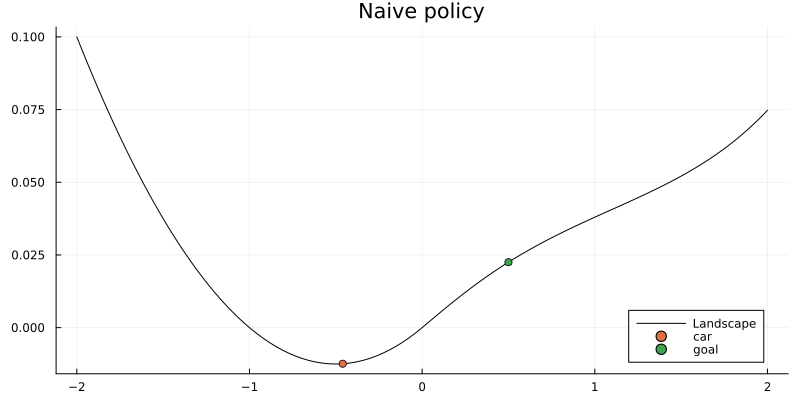

In [6]:
N_naive  = 100 # Total simulation time
pi_naive = 100.0 * ones(N_naive) # Naive policy for right full-power only

# Let there be a world
(execute_naive, observe_naive) = create_world(; 
    Fg = Fg, Ff = Ff, Fa = Fa, 
    initial_position = initial_position, 
    initial_velocity = initial_velocity
);

y_naive = Vector{Vector{Float64}}(undef, N_naive)
for t = 1:N_naive
    execute_naive(pi_naive[t]) # Execute environmental process
    y_naive[t] = observe_naive() # Observe external states
end

animation_naive = @animate for i in 1:N_naive
    plot(valley_x, valley_y, title = "Naive policy", label = "Landscape", color = "black", size = (800, 400))
    scatter!([y_naive[i][1]], [height(y_naive[i][1])], label="car")
    scatter!([x_target[1]], [height(x_target[1])], label="goal")   
end

gif(animation_naive, "./pics/ai-mountain-car-naive.gif", fps = 24, show_msg = false)

They failed as expected since the car doesn't have enough power. This helps to understand that the brute-force approach is not the most efficient one in this case and hopefully a bit of swinging is necessary to achieve the goal.

# Active inference approach

Now let's help they solving the problem with active inference approach. Particularly, we create an agent that predicts the future car position as well as the best possible actions in a probabilistic manner.

We start by specifying a probabilistic model for the agent that describes the agent's internal beliefs over the external dynamics of the environment. The generative model is defined as follows
\begin{equation}
p_t(x,s,u) \propto p(s_{t-1}) \prod_{k=1}^{t+T} p(x_k|s_k) \, p(s_k|s_{k-1},u_k) \, p(u_k) \, p'(x_k) \nonumber
\end{equation} 
where the factors are defined as
$$p'(x_k) = \mathcal{N}(x_k \mid x_{goal},\,V_{goal}) , \quad (\mathrm{target}) $$
$$p(s_k|s_{k-1},u_k) = \mathcal{N}(s_k \mid \tilde{g}(s_{k-1})+h(u_k),\,\gamma^{-1}) , \quad (\mathrm{state \,\, transition})$$
$$p(x_k|s_k) = \mathcal{N}(x_k \mid s_k,\,\theta), \quad (\mathrm{observation}) $$
$$p(u_k) = \mathcal{N}(u_k \mid m_u,\,V_u), \quad (\mathrm{control}) $$
$$p(s_{t-1}) = \mathcal{N}(s_{t-1} \mid m_{t-1},\,V_{t-1}), \quad (\mathrm{previous \,\, state}) $$
where 
- $x$ denotes observations of the agent after interacting with the environment; 
- $s_t = (s_t,\dot{s_t})$ is the state of the car embodying its position and velocity; 
- $u_t$ denotes the control state of the agent; 
- $h(\cdot)$ is the $\tanh(\cdot)$ function modeling engine control; 
- $\tilde{g}(\cdot)$ executes a linear approximation of equations (1) and (2): 
\begin{align} 
\dot{s_t} &= \dot{s}_{t-1} + F_g(s_{t-1}) + F_f(\dot{s}_{t-1}) \nonumber\\
s_t &= s_{t-1} + \dot{s_t} \nonumber
\end{align}

In the cell below, the ```@model``` macro and the `meta` blocks are used to define the probabilistic model and the approximation methods for the nonlinear state-transition functions, respectively. In addition, the beliefs over the future states (up to T steps ahead) of the agent is included.


In [7]:
@model function mountain_car(; T, Fg, Fa, Ff, engine_force_limit)
    
    # Transition function modeling transition due to gravity and friction
    g = (s_t_min::AbstractVector) -> begin 
        s_t = similar(s_t_min) # Next state
        s_t[2] = s_t_min[2] + Fg(s_t_min[1]) + Ff(s_t_min[2]) # Update velocity
        s_t[1] = s_t_min[1] + s_t[2] # Update position
        return s_t
    end
    
    # Function for modeling engine control
    h = (u::AbstractVector) -> [0.0, Fa(u[1])] 
    
    # Inverse engine force, from change in state to corresponding engine force
    h_inv = (delta_s_dot::AbstractVector) -> [atanh(clamp(delta_s_dot[2], -engine_force_limit+1e-3, engine_force_limit-1e-3)/engine_force_limit)] 
    
    # Internal model perameters
    Gamma = 1e4*diageye(2) # Transition precision
    Theta = 1e-4*diageye(2) # Observation variance
    
    m_s_t_min = datavar(Vector{Float64})
    V_s_t_min = datavar(Matrix{Float64})

    s_t_min ~ MvNormal(mean = m_s_t_min, cov = V_s_t_min)
    s_k_min = s_t_min
    
    m_u = datavar(Vector{Float64}, T)
    V_u = datavar(Matrix{Float64}, T)
    
    m_x = datavar(Vector{Float64}, T)
    V_x = datavar(Matrix{Float64}, T)
    
    u = randomvar(T)
    s = randomvar(T)
    x = randomvar(T)
    
    u_h_k = randomvar(T)
    s_g_k = randomvar(T)
    u_s_sum = randomvar(T)
    
    for k in 1:T
        u[k] ~ MvNormal(mean = m_u[k], cov = V_u[k])
        u_h_k[k] ~ h(u[k]) where { meta = DeltaMeta(method = Linearization(), inverse = h_inv) }
        s_g_k[k] ~ g(s_k_min) where { meta = DeltaMeta(method = Linearization()) }
        u_s_sum[k] ~ s_g_k[k] + u_h_k[k]
        s[k] ~ MvNormal(mean = u_s_sum[k], precision = Gamma)
        x[k] ~ MvNormal(mean = s[k], cov = Theta)
        x[k] ~ MvNormal(mean = m_x[k], cov = V_x[k]) # goal
        s_k_min = s[k]
    end
    
    return (s, )
end

After specifying the generative model, let's create an Active Inference(AI) agent for the car. 
Technically, the agent goes through three phases: **Act-Execute-Observe**, **Infer** and **Slide**.
1. **Act-Execute-Observe**: 
    In this phase, the agent performs an action onto the environment at time $t$ and gets $T$ observations in exchange. These observations are basically the prediction of the agent on how the environment evolves over the next $T$ time step. 
2. **Infer**:
    After receiving observations, the agent starts updating its internal probabilistic model by doing inference. Particularly, it finds the posterior distributions over the state $s_t$ and control $u_t$, i.e. $p(s_t|x_t)$ and $p(u_t|x_t)$.
3. **Slide**:
    After updating its internal belief, the agent moves to the next time step and uses the inferred action $u_t$ in the previous time step to interact with the environment.  

In the cell below, we create the agent through the `create_agent` function, which includes `infer`, `act`, `slide` and `future` functions:
- The `act` function selects the next action based on the inferred policy. On the other hand, the `future` function predicts the next $T$ positions based on the current action. These two function implement the **Act-Execute-Observe** phase.
- The `infer` function infers the policy (which is a set of actions for the next $T$ time steps) and the agent's state using the agent internal model. This function implements the **Infer** phase.
- The `slide` function implements the **Slide** phase, which moves the agent internal model to the next time step.

In [8]:
# We are going to use some private functionality from ReactiveMP, 
# in the future we should expose a proper API for this
import RxInfer.ReactiveMP: getrecent, messageout

function create_agent(; T = 20, Fg, Fa, Ff, engine_force_limit, x_target, initial_position, initial_velocity)
    Epsilon = fill(huge, 1, 1)                # Control prior variance
    m_u = Vector{Float64}[ [ 0.0] for k=1:T ] # Set control priors
    V_u = Matrix{Float64}[ Epsilon for k=1:T ]

    Sigma    = 1e-4*diageye(2) # Goal prior variance
    m_x      = [zeros(2) for k=1:T]
    V_x      = [huge*diageye(2) for k=1:T]
    V_x[end] = Sigma # Set prior to reach goal at t=T

    # Set initial brain state prior
    m_s_t_min = [initial_position, initial_velocity] 
    V_s_t_min = tiny * diageye(2)
    
    # Set current inference results
    result = nothing

    # The `infer` function is the heart of the agent
    # It calls the `RxInfer.inference` function to perform Bayesian inference by message passing
    infer = (upsilon_t::Float64, y_hat_t::Vector{Float64}) -> begin
        m_u[1] = [ upsilon_t ] # Register action with the generative model
        V_u[1] = fill(tiny, 1, 1) # Clamp control prior to performed action

        m_x[1] = y_hat_t # Register observation with the generative model
        V_x[1] = tiny*diageye(2) # Clamp goal prior to observation

        data = Dict(:m_u       => m_u, 
                    :V_u       => V_u, 
                    :m_x       => m_x, 
                    :V_x       => V_x,
                    :m_s_t_min => m_s_t_min,
                    :V_s_t_min => V_s_t_min)
        
        model  = mountain_car(; T = T, Fg = Fg, Fa = Fa, Ff = Ff, engine_force_limit = engine_force_limit) 
        result = inference(model = model, data = data)
    end
    
    # The `act` function returns the inferred best possible action
    act = () -> begin
        if result !== nothing
            return mode(result.posteriors[:u][2])[1]
        else
            return 0.0 # Without inference result we return some 'random' action
        end
    end
    
    # The `future` function returns the inferred future states
    future = () -> begin 
        if result !== nothing 
            return getindex.(mode.(result.posteriors[:s]), 1)
        else
            return zeros(T)
        end
    end

    # The `slide` function modifies the `(m_s_t_min, V_s_t_min)` for the next step
    # and shifts (or slides) the array of future goals `(m_x, V_x)` and inferred actions `(m_u, V_u)`
    slide = () -> begin
        (s, ) = result.returnval
        
        slide_msg_idx = 3 # This index is model dependend
        (m_s_t_min, V_s_t_min) = mean_cov(getrecent(messageout(s[2], slide_msg_idx)))

        m_u = circshift(m_u, -1)
        m_u[end] = [0.0]
        V_u = circshift(V_u, -1)
        V_u[end] = Epsilon

        m_x = circshift(m_x, -1)
        m_x[end] = x_target
        V_x = circshift(V_x, -1)
        V_x[end] = Sigma
    end

    return (infer, act, slide, future)    
end

create_agent (generic function with 1 method)

Now it's time to see if we can help our friends arrive at the camping site by midnight?

Plots.AnimatedGif("/Users/nguyenhuuminhhoang/PhD/RxInfer.jl/examples/pics/ai-mountain-car-ai.gif")
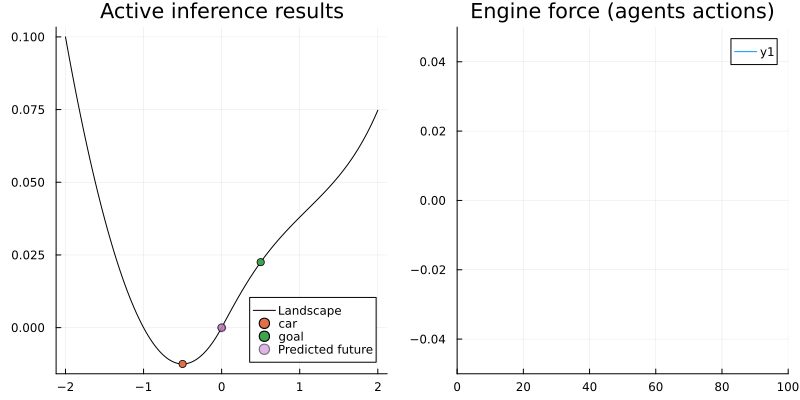

In [9]:
(execute_ai, observe_ai) = create_world(
    Fg = Fg, Ff = Ff, Fa = Fa, 
    initial_position = initial_position, 
    initial_velocity = initial_velocity
) # Let there be a world

T_ai = 50

(infer_ai, act_ai, slide_ai, future_ai) = create_agent(; # Let there be an agent
    T  = T_ai, 
    Fa = Fa,
    Fg = Fg, 
    Ff = Ff, 
    engine_force_limit = engine_force_limit,
    x_target = x_target,
    initial_position = initial_position,
    initial_velocity = initial_velocity
) 

N_ai = 100

# Step through experimental protocol
agent_a = Vector{Float64}(undef, N_ai) # Actions
agent_f = Vector{Vector{Float64}}(undef, N_ai) # Predicted future
agent_x = Vector{Vector{Float64}}(undef, N_ai) # Observations

for t=1:N_ai
    agent_a[t] = act_ai()            # Invoke an action from the agent
    agent_f[t] = future_ai()         # Fetch the predicted future states
    execute_ai(agent_a[t])           # The action influences hidden external states
    agent_x[t] = observe_ai()        # Observe the current environmental outcome (update p)
    infer_ai(agent_a[t], agent_x[t]) # Infer beliefs from current model state (update q)
    slide_ai()                       # Prepare for next iteration
end

animation_ai = @animate for i in 1:N_ai
    # pls - plot landscape
    pls = plot(valley_x, valley_y, title = "Active inference results", label = "Landscape", color = "black")
    pls = scatter!(pls, [agent_x[i][1]], [height(agent_x[i][1])], label="car")
    pls = scatter!(pls, [x_target[1]], [height(x_target[1])], label="goal")   
    pls = scatter!(pls, agent_f[i], height.(agent_f[i]), label = "Predicted future", alpha = map(i -> 0.5 / i, 1:T_ai))
    
    # pef - plot engine force
    pef = plot(Fa.(agent_a[1:i]), title = "Engine force (agents actions)", xlim = (0, N_ai), ylim = (-0.05, 0.05))
    
    plot(pls, pef, size = (800, 400))
end
    
gif(animation_ai, "./pics/ai-mountain-car-ai.gif", fps = 24, show_msg = false)

Voila!!! The car now is able to reach the camping site with a smart strategy.

The left figure shows the agent reached its goal by swinging and the right one shows the corresponding engine force. As we can see, at the beginning the agent tried to reach the goal directly (with full engine force) but after some trials it realized that's not possible. Since the agent looks ahead for 50 time steps, it has enough time to explore other policies, helping it learn to move back to get more momentum to reach the goal.

Now our friends can enjoy their trip at the camping site!!!. 

# Reference

We refer reader to the Thijs van de Laar (2019) "Simulating active inference processes by message passing" original paper with more in-depth overview and explanation of the active inference agent implementation by message passing.
The original environment/task description is from Ueltzhoeffer (2017) "Deep active inference".